Importación de Librerías

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
import matplotlib.pyplot as plt

Contar Imágenes en las Carpetas de Categorías

In [3]:
contador = 0
carpetas = os.listdir('Images/')
for carpeta in carpetas:
    archivos = list(os.listdir('Images/' + carpeta))
    print(carpeta + ' tiene ' + str(len(archivos)) + ' imágenes')
    contador += len(archivos)
print('La carpeta de imágenes tiene ' + str(contador) + ' imágenes')

bebidas tiene 250 imágenes
carnes tiene 213 imágenes
dormitorio tiene 275 imágenes
frutas_verduras tiene 200 imágenes
oficina tiene 250 imágenes
La carpeta de imágenes tiene 1188 imágenes


Configuración del Conjunto de Datos

In [5]:
directorio_base = 'Images/'
tamano_img = 180
tamano_lote = 32

entrenamiento_ds = tf.keras.utils.image_dataset_from_directory(directorio_base,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               subset='training',
                                                               batch_size=tamano_lote,
                                                               image_size=(tamano_img, tamano_img))

validacion_ds = tf.keras.utils.image_dataset_from_directory(directorio_base,
                                                            seed=123,
                                                            validation_split=0.2,
                                                            subset='validation',
                                                            batch_size=tamano_lote,
                                                            image_size=(tamano_img, tamano_img))

nombres_categorias = entrenamiento_ds.class_names
nombres_categorias

Found 1188 files belonging to 5 classes.
Using 951 files for training.
Found 1188 files belonging to 5 classes.
Using 237 files for validation.


['bebidas', 'carnes', 'dormitorio', 'frutas_verduras', 'oficina']

Muestra de Algunas Imágenes de Entrenamiento

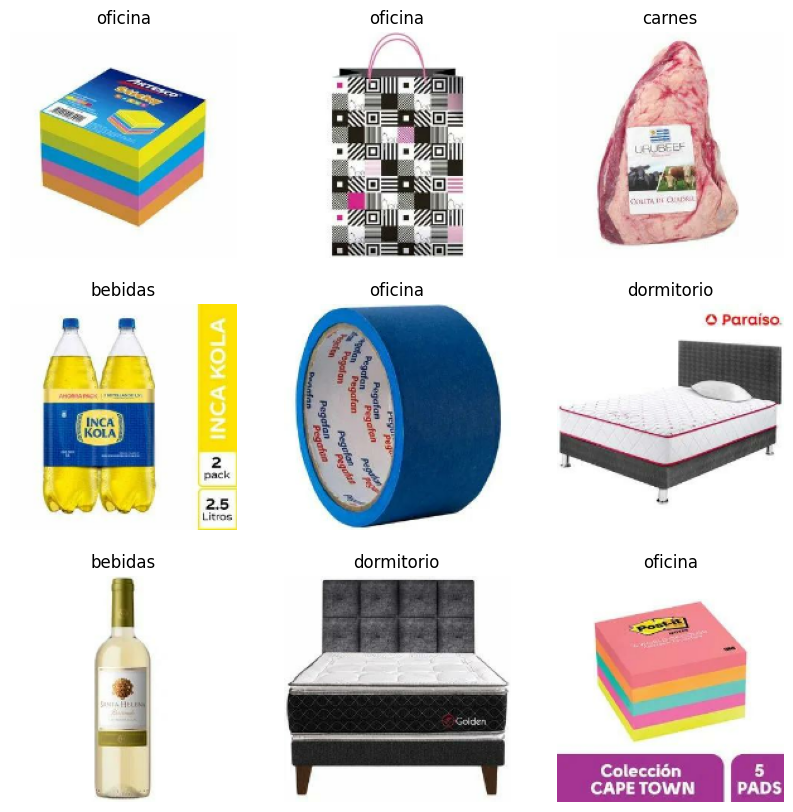

In [6]:
plt.figure(figsize=(10, 10))
for imagenes, etiquetas in entrenamiento_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(imagenes[i].numpy().astype('uint8'))
        plt.title(nombres_categorias[etiquetas[i]])
        plt.axis('off')
plt.show()


Optimización del Conjunto de Datos

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
entrenamiento_ds = entrenamiento_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validacion_ds = validacion_ds.cache().prefetch(buffer_size=AUTOTUNE)

Aumento de Datos

d:\laragon\bin\python\python-3.10\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


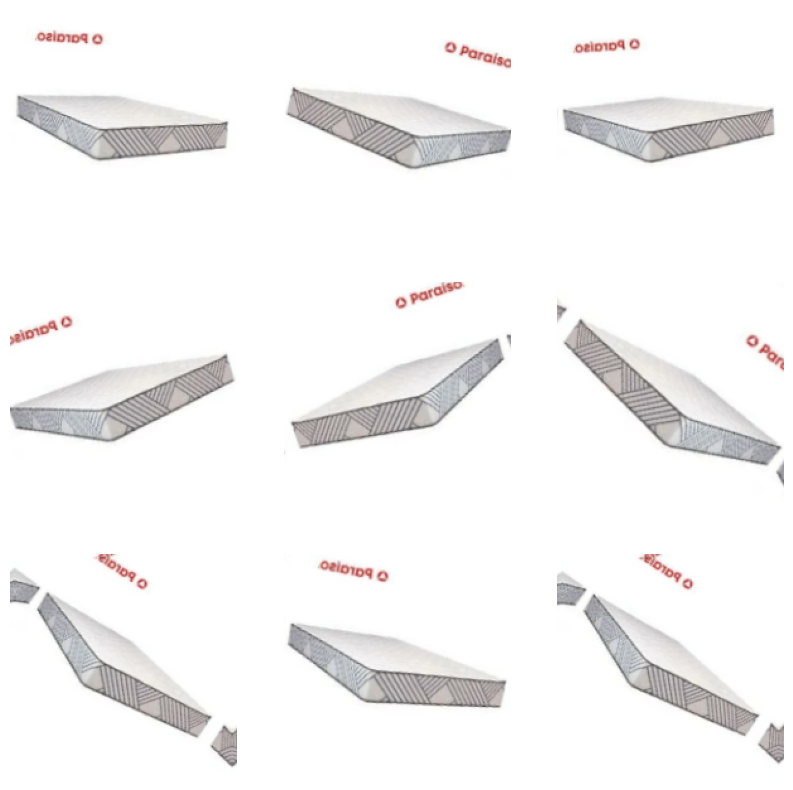

In [8]:
aumento_datos = Sequential([
    layers.RandomFlip("horizontal", input_shape=(tamano_img, tamano_img, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

plt.figure(figsize=(10, 10))
for imagenes, etiquetas in entrenamiento_ds.take(1):
    for i in range(9):
        imagenes_aumentadas = aumento_datos(imagenes)
        plt.subplot(3, 3, i + 1)
        plt.imshow(imagenes_aumentadas[0].numpy().astype('uint8'))
        plt.axis('off')
plt.show()

Construcción del Modelo

In [16]:
modelo = Sequential([
    aumento_datos,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)  
])

modelo.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])


Entrenamiento del Modelo

In [18]:
historia = modelo.fit(entrenamiento_ds, epochs=25, validation_data=validacion_ds)

Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.8815 - loss: 0.3093 - val_accuracy: 0.7384 - val_loss: 1.0125
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.8865 - loss: 0.3386 - val_accuracy: 0.7468 - val_loss: 1.0322
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - accuracy: 0.8734 - loss: 0.3202 - val_accuracy: 0.7215 - val_loss: 1.1845
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.9187 - loss: 0.2347 - val_accuracy: 0.7764 - val_loss: 0.9803
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.8592 - loss: 0.3617 - val_accuracy: 0.6751 - val_loss: 1.3943
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.8893 - loss: 0.2862 - val_accuracy: 0.7131 - val_loss: 1.1735
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.8934 - loss: 0.2703 - val_accuracy: 0.7764 - val_loss: 1.0320
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9097 - loss: 0.2585 - val_accuracy: 0.

Función para Clasificar Imágenes

In [41]:
def clasificar_imagenes(ruta_imagen):
    imagen_entrada = tf.keras.utils.load_img(ruta_imagen, target_size=(tamano_img, tamano_img))
    imagen_entrada_array = tf.keras.utils.img_to_array(imagen_entrada)
    imagen_entrada_exp_dim = tf.expand_dims(imagen_entrada_array, 0)

    predicciones = modelo.predict(imagen_entrada_exp_dim)
    resultado = tf.nn.softmax(predicciones[0])

    indices_mayores = np.argsort(resultado)[-2:][::-1]
    
    resultado_primero = nombres_categorias[indices_mayores[0]]
    puntuacion_primero = resultado[indices_mayores[0]] * 100
    resultado_segundo = nombres_categorias[indices_mayores[1]]
    puntuacion_segundo = resultado[indices_mayores[1]] * 100

    resultado_final = (f'La imagen pertenece a {resultado_primero} con una puntuación de {puntuacion_primero:.2f}%. \n'
                       f'La segunda opción más probable es {resultado_segundo} con una puntuación de {puntuacion_segundo:.2f}%.')

    return resultado_final

print(clasificar_imagenes('output/cama.jpg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
La imagen pertenece a dormitorio con una puntuación de 99.31%. 
La segunda opción más probable es bebidas con una puntuación de 0.32%.


Guardado el Modelo

In [40]:
modelo.save('Modelo_Reconocimiento_Mercado.keras')